In [1]:
import os
import cv2
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_dir = "data/train"
val_dir = "data/validation"

In [3]:
def get_train_transform():
    return T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(15),
        T.RandomCrop(204),
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])
    
def get_val_transform():
    return T.Compose([
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])

In [4]:
class CatDogDataset(Dataset):
    """
    Cat dog classifier Dataset loader class
    """
    
    class_mapper = {"cat": 0, "dog": 1}
    
    def __init__(self, image_dir, transforms = None):
        
        super().__init__()
        self.image_dir = image_dir
        self.transforms = transforms
        
        assert os.listdir(image_dir) == ['cats', 'dogs'], "incorrect dataset structure"
        
        cat_image_dir = os.path.join(self.image_dir, "cats")
        dog_image_dir = os.path.join(self.image_dir, "dogs")
        cat_imgs = [os.path.join(cat_image_dir, i) for i in os.listdir(cat_image_dir)]
        dog_imgs = [os.path.join(dog_image_dir, i) for i in os.listdir(dog_image_dir)]
        
        self.imgs = cat_imgs + dog_imgs
        
    def __getitem__(self, idx):
        
        image_name = self.imgs[idx]
        
        img = Image.open(image_name)
        img = img.resize((224, 224))
                
        class_name = self.image_path_to_class_name(image_name)
        label = self.class_mapper[class_name]
        
        label = torch.tensor(label, dtype = torch.float32)
        
        if self.transforms:
            img = self.transforms(img)
            
        else:
            img = torch.tensor(img, dtype = torch.float32)
        
        return img, label

    @staticmethod
    def image_path_to_class_name(image_path):
        return os.path.dirname(image_path).split("/")[-1][:-1]
    
    def __len__(self):
        return len(self.imgs)
        
train_dataset = CatDogDataset(image_dir=train_dir, transforms=get_train_transform())
val_dataset = CatDogDataset(image_dir=val_dir, transforms=get_val_transform())


In [5]:
BATCH_SIZE = 4
NUM_WORKERS = 2

In [6]:
train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = NUM_WORKERS,
    batch_size = BATCH_SIZE,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = NUM_WORKERS,
    batch_size = BATCH_SIZE,
    shuffle = False
)


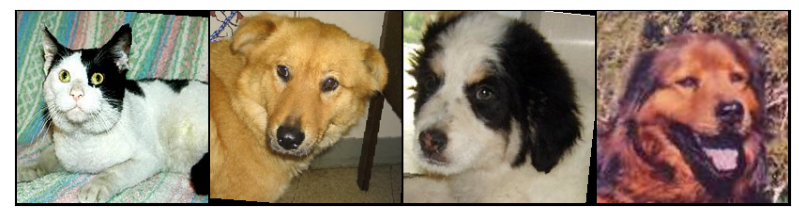

In [7]:
for images, labels in train_data_loader:
    
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break
    

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
def accuracy(preds, trues):
    
    ### Converting preds to 0 or 1
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    
    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    
    ### Summing over all correct predictions
    acc = np.sum(acc) / len(preds)
    
    return (acc * 100)
    

In [10]:
def train_one_epoch(train_data_loader):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in train_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
        #Backward
        _loss.backward()
        optimizer.step()
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in val_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    ###Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),"resnet50_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc
        
        

In [11]:
model = resnet50(pretrained = True)

# Modifying Head - classifier

model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

/home/ostyk/Desktop/repos/dvc-tutorial/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ostyk/Desktop/repos/dvc-tutorial/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 2

# TODO: 
- accumulate metrics
- save pytorch model

In [13]:
best_val_acc = 0
for epoch in range(epochs):
    
    ###Training
    loss, acc, _time = train_one_epoch(train_data_loader)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)
    
    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    


Training
Epoch 1
Loss : 0.3436
Acc : 86.9
Time : 14.9586

Validating
Epoch 1
Loss : 1.0065
Acc : 56.0
Time : 3.5126

Training
Epoch 2
Loss : 0.261
Acc : 90.0
Time : 14.0078

Validating
Epoch 2
Loss : 0.7418
Acc : 67.75
Time : 3.5016


In [14]:
torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")